# Life-Saver Classifier

Tell apart poisonous and safe lookalike plants. Works for these plants:

- Wild grapes (safe) and moonseed (poisonous)
- Blueberries (safe) and deadly nightshade (poisonous)

Steps:
1. Use DuckDuckGo to search for images of "wild grape photos"
2. Use DuckDuckGo to search for images of "moonseed photos"
3. Use DuckDuckGo to search for images of "blueberries photos"
4. Use DuckDuckGo to search for images of "deadly nightshade photos"
5. Augment the images
6. Fine-tune a pretrained neural network to recognise these two groups
7. Try running this model on pictures and see if it works.
8. Export the model.
9. Build app that calls the model.

In [15]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.vision import *

In [1]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
# Test URL lookup

urls = search_images('wild grapes fruit', max_images=1)
urls[0]

Searching for 'wild grapes fruit'


'http://northernwoodlands.org/images/articles/wild-grapes-Hazel-Stark.jpg'

Initial image lookup:

Searching for 'wild grapes fruit'


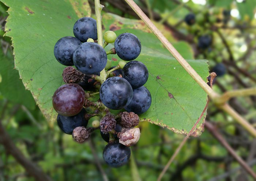

In [2]:
download_url(search_images('wild grapes fruit', max_images=1)[0], 'grapes.jpg', show_progress=False)
Image.open('grapes.jpg').to_thumb(256,256)

Searching for 'blue moonseed fruit'


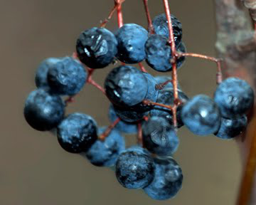

In [5]:
download_url(search_images('blue moonseed fruit', max_images=1)[0], 'moonseed.jpg', show_progress=False)
Image.open('moonseed.jpg').to_thumb(256,256)

Searching for 'blueberries bush'


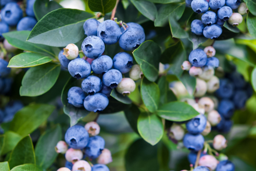

In [6]:
download_url(search_images('blueberries bush', max_images=1)[0], 'blueberries.jpg', show_progress=False)
Image.open('blueberries.jpg').to_thumb(256,256)

Searching for 'deadly nightshade fruit'


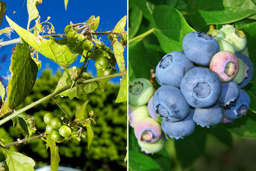

In [7]:
download_url(search_images('deadly nightshade fruit', max_images=1)[0], 'nightshade.jpg', show_progress=False)
Image.open('nightshade.jpg').to_thumb(256,256)

In [4]:
# Download images for training

searches = 'wild grapes fruit', 'blue moonseed fruit', 'blueberries bush', 'deadly nightshade fruit'
path = Path('plants')
from time import sleep

for plant in searches:
    dest = (path/plant)
    dest.mkdir(exist_ok=True, parents=True)
    download_images (dest, urls=search_images(f' {plant} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images (dest, urls=search_images(f' {plant} sun photo'))
    sleep(10)
    download_images (dest, urls=search_images(f' {plant} shade photo'))
    resize_images(path/plant, max_size=400, dest=path/plant)

In [9]:
# Check paths

fns = get_image_files(path)
fns

(#690) [Path('plants/blue moonseed fruit/253fb58d-2760-492e-858e-8198b942c20d.jpg'),Path('plants/blue moonseed fruit/410af774-e0c1-49ad-a2bb-075ae579e2c5.jpg'),Path('plants/blue moonseed fruit/1e29d223-a127-43d6-92be-1fb0cedd6ddf.JPG'),Path('plants/blue moonseed fruit/7c7ff062-f5c0-4b0f-860c-ccc49bfffd5f.jpg'),Path('plants/blue moonseed fruit/90226252-c060-4049-be86-95046311d02f.jpg'),Path('plants/blue moonseed fruit/8d44f6e2-52d3-4692-bad7-9256a52d2205.JPG'),Path('plants/blue moonseed fruit/c742b2ae-e929-4318-8f68-d4a110ff34ea.jpg'),Path('plants/blue moonseed fruit/10dcf407-8a56-4bea-8516-1b7de3274576.png'),Path('plants/blue moonseed fruit/3cced294-cb0f-4e4a-ae01-c680491c24d9.jpg'),Path('plants/blue moonseed fruit/a332968e-cadb-4340-bcba-3568ab5ced65.jpg')...]

In [5]:
# Remove failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

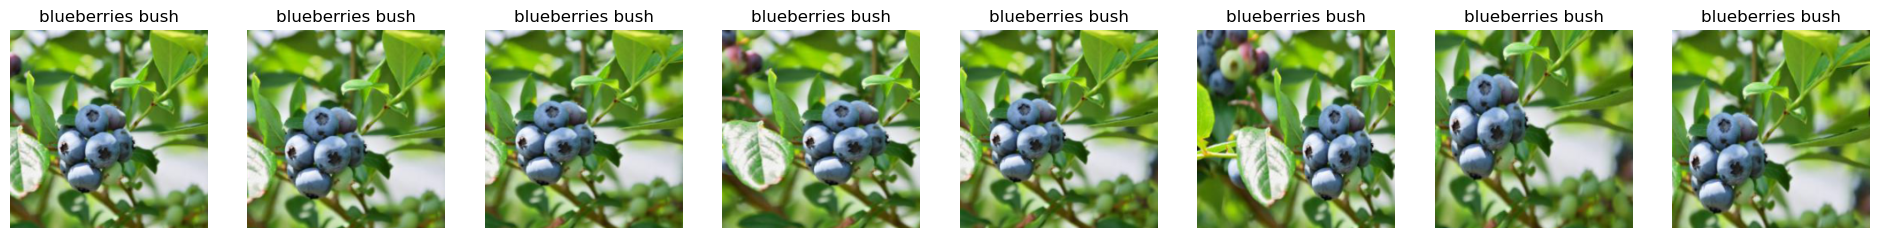

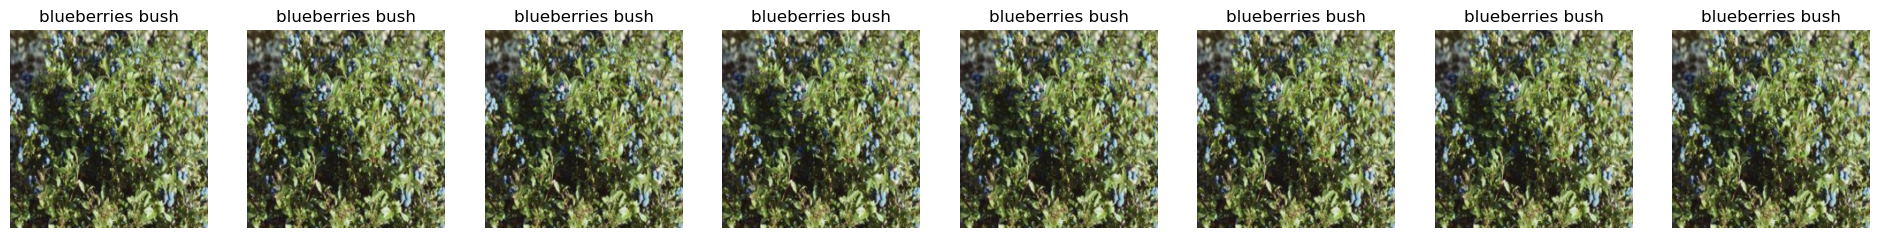

In [5]:
# Create train and valid DataLoaders

plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=27),
    item_tfms=RandomResizedCrop(224, min_scale=0.5))

dls = plants.dataloaders('plants')
dls.train.show_batch(max_n=8, nrows=1, unique=True)
dls.valid.show_batch(max_n=8, nrows=1, unique=True)

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/yaroslavshipilov/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yaroslavshipilov/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/yaroslavshipilov/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.128777,2.380298,0.529412,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.436810,1.394359,0.470588,00:03
1,1.215324,0.876906,0.338235,00:02
2,1.064703,0.803627,0.279412,00:02
3,0.906004,0.767776,0.264706,00:02


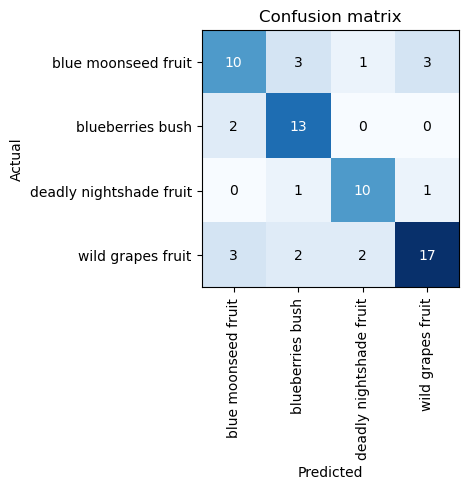

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

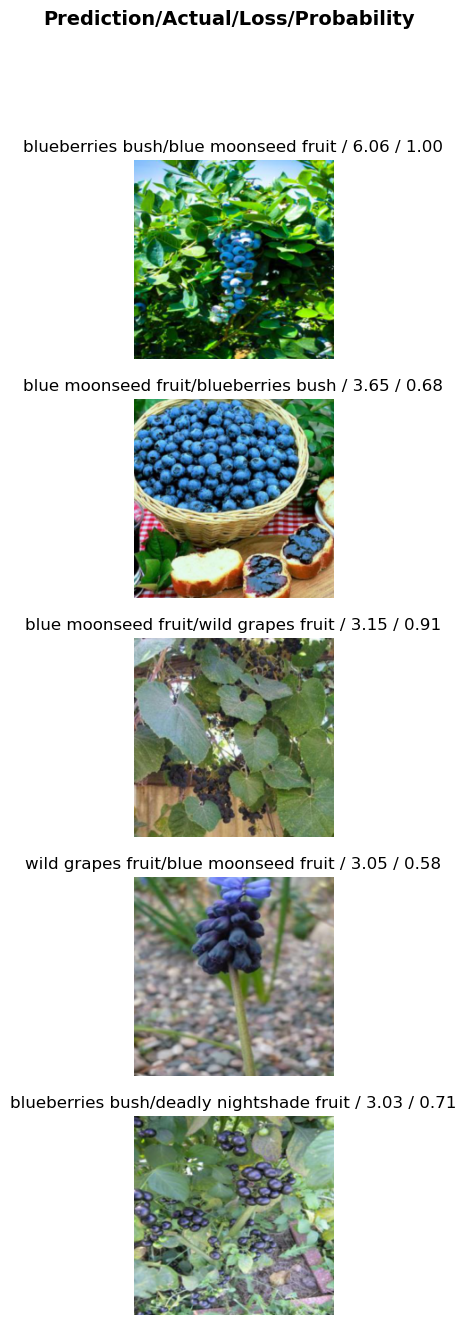

In [10]:
interp.plot_top_losses(5, nrows=5)

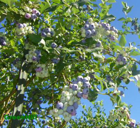

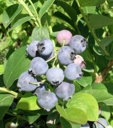

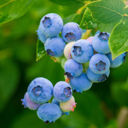

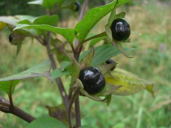

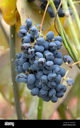

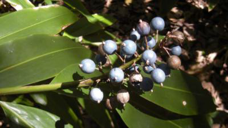

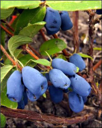

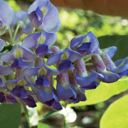

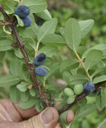

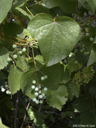

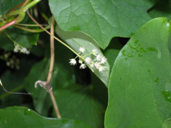

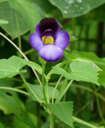

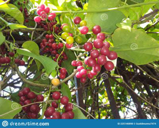

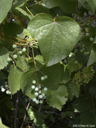

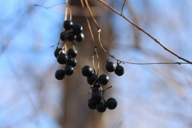

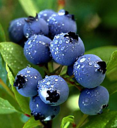

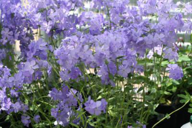

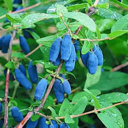

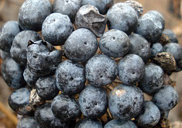

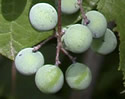

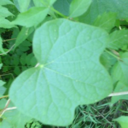

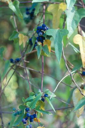

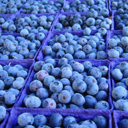

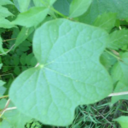

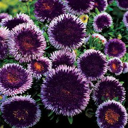

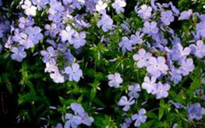

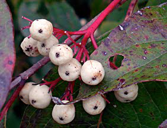

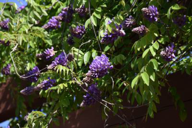

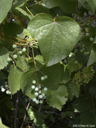

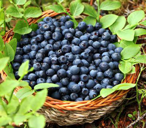

In [18]:
cleaner = ImageClassifierCleaner(learn)
cleaner